# Operational Research Assignment 2025
## Planning of weekly course timetable
### Lolos Ioannis - 10674
### lolosioann@ece.auth.gr

In [8]:
# imports
from gurobipy import Model, GRB
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [9]:
# Data representation

teachers = [
    "Gesmanidis",       
    "Insulina",   
    "Chartoula",  
    "Lathopraxis",
    "Antiparagogos",
    "Kirkofidou",
    "Platiazon",
    "Bratsakis",
    "Trehalitoula"
]

subjects = {
    "English": "Gesmanidis",
    "Biology": "Insulina",
    "History": "Chartoula",
    "Math_1": "Lathopraxis",      
    "Math_2": "Antiparagogos",    
    "Physics": "Kirkofidou",
    "Philosophy": "Platiazon",
    "PE_1": "Bratsakis",          
    "PE_2": "Trehalitoula"        
}

sections = ["T1", "T2"]

days = ["Mon", "Tue", "Wed", "Thu", "Fri"]
slots_per_day = ["08_10", "10_15_12_15", "14_16", "16_15_18_15"]

time_slots = [(d, s) for d in days for s in slots_per_day]

teaching_hours = {     # subject: (T1_hours, T2_hours)
    "English": (1, 1),
    "Biology": (3, 3),
    "History": (2, 2),
    "Math_1": (0, 4),   # Lathopraxis
    "Math_2": (4, 0),   # Antiparagogos
    "Physics": (3, 3),
    "Philosophy": (1, 1),
    "PE_1": (1, 0),
    "PE_2": (0, 1)
}

# Fixed slot reserved for study planning
reserved_slots = [("Mon", "08_10")]

# PE must be on Thursday 14:00-16:00
pe_slot = ("Thu", "14_16")

# Teacher availability
unavailable = {
    "Lathopraxis": [("Mon", "08_10"), ("Mon", "10_15_12_15")],
    "Insulina": [("Wed", s) for s in slots_per_day]
}

# One lesson per subject per section per day
# This will be enforced through constraints

In [3]:
# create the model
x = {}  # Decision variables: x[section, subject, time_slot]
model = Model("timetabling")

for s in sections:
    for sub in teaching_hours:
        for t in time_slots:
            var_name = f"x_{s}_{sub}_{t[0]}_{t[1]}"
            x[s, sub, t] = model.addVar(vtype=GRB.BINARY, name=var_name)

# there is nothing to minimize, but we need to set an objective function
model.setObjective(0, GRB.MINIMIZE)

Restricted license - for non-production use only - expires 2026-11-23


In [4]:
# constraints

# Each subject sub must be scheduled exactly H times for each section s:
for sub, (h1, h2) in teaching_hours.items():
    for s_idx, s in enumerate(sections):
        H = h1 if s_idx == 0 else h2
        model.addConstr(sum(x[s, sub, t] for t in time_slots) == H)


# Each section can attend only one class at a time:
for s in sections:
    for t in time_slots:
        model.addConstr(sum(x[s, sub, t] for sub in teaching_hours) <= 1)


# We must ensure that a teacher is not scheduled to teach two sections at the same time.
for t in time_slots:
    for teacher in teachers:
        teaching_subs = [sub for sub, tchr in subjects.items() if tchr == teacher]
        model.addConstr(
            sum(x[s, sub, t] for s in sections for sub in teaching_subs) <= 1
        )

# No More Than One Lesson per Subject per Section per Day
for s in sections:
    for sub in teaching_hours:
        for day in days:
            slots_today = [t for t in time_slots if t[0] == day]
            model.addConstr(sum(x[s, sub, t] for t in slots_today) <= 1)

# fixed slot reserved for study planning
for s in sections:
    for sub in teaching_hours:
        for t in reserved_slots:
            model.addConstr(x[s, sub, t] == 0)

# PE must be on Thursday 14:00-16:00
pe_allowed = ("Thu", "14_16")
for t in time_slots:
    if t != pe_allowed:
        model.addConstr(x["T1", "PE_1", t] == 0)
        model.addConstr(x["T2", "PE_2", t] == 0)

# Teachers' Unavailability
for teacher, unavailable_slots in unavailable.items():
    teaching_subs = [sub for sub, tchr in subjects.items() if tchr == teacher]
    for s in sections:
        for sub in teaching_subs:
            for t in unavailable_slots:
                model.addConstr(x[s, sub, t] == 0)


In [5]:
model.setParam('OutputFlag', 0)
model.optimize()
# Print the results
from gurobipy import GRB

if model.status == GRB.OPTIMAL:
    print("✅ Optimal solution found!\n")
else:
    print("⚠️ No feasible solution.")


✅ Optimal solution found!



In [6]:
def build_timetable_for_section(section):
    table = pd.DataFrame(index=slots_per_day, columns=days)

    for day in days:
        for slot in slots_per_day:
            t = (day, slot)
            subject = "---"
            for sub in teaching_hours:
                if x[section, sub, t].X > 0.5:
                    subject = sub
                    break
            table.at[slot, day] = subject

    return table

for section in sections:
    print(f"\n📘 Timetable for {section}")
    timetable = build_timetable_for_section(section)
    print(timetable)



📘 Timetable for T1
                 Mon      Tue         Wed      Thu      Fri
08_10            ---  History         ---  Biology   Math_2
10_15_12_15  Physics  Physics  Philosophy  History  Physics
14_16         Math_2      ---      Math_2     PE_1  English
16_15_18_15  Biology      ---         ---   Math_2  Biology

📘 Timetable for T2
                 Mon         Tue      Wed      Thu      Fri
08_10            ---     Biology   Math_1      ---  Biology
10_15_12_15  History      Math_1      ---   Math_1      ---
14_16        Biology  Philosophy      ---     PE_2  Physics
16_15_18_15   Math_1     Physics  Physics  English  History


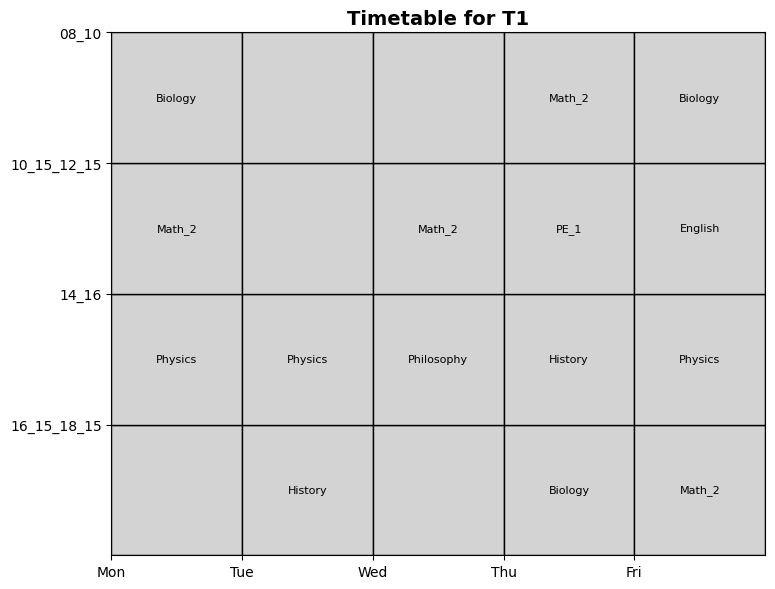

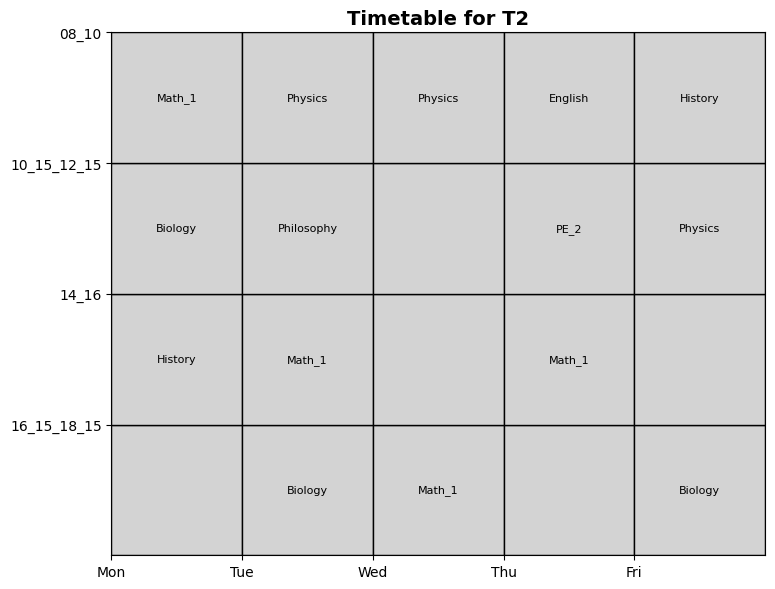

In [7]:
def plot_timetable(section):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim(0, len(days))
    ax.set_ylim(0, len(slots_per_day))
    ax.set_xticks(range(len(days)))
    ax.set_yticks(range(len(slots_per_day)))
    ax.set_xticklabels(days)
    ax.set_yticklabels(slots_per_day)
    ax.set_title(f"Timetable for {section}", fontsize=14, weight='bold')

    # Draw grid and fill cells with subject names
    for i, slot in enumerate(slots_per_day):
        for j, day in enumerate(days):
            t = (day, slot)
            subject = None
            for sub in teaching_hours:
                if x[section, sub, t].X > 0.5:
                    subject = sub
                    break
            rect = patches.Rectangle((j, len(slots_per_day) - 1 - i), 1, 1, linewidth=1, edgecolor='black', facecolor='lightgrey')
            ax.add_patch(rect)
            if subject:
                ax.text(j + 0.5, len(slots_per_day) - 1 - i + 0.5, subject, ha='center', va='center', fontsize=8, wrap=True)

    ax.invert_yaxis()
    ax.set_aspect('equal')
    plt.grid(False)
    plt.tight_layout()
    plt.show()


for section in sections:
    plot_timetable(section)
